# 🎯 VTOL Vision Dataset Analysis & YOLO Model Planning

## 🚁 Project Overview
This notebook analyzes our comprehensive dataset for **VTOL competition vision system** and plans the optimal YOLO model deployment strategy for **Raspberry Pi**.

### 📁 Dataset Components:
- **🔺 Shapes**: 500 images with 12 geometric shapes (Circle, Rectangle, Triangle, Pentagon, Hexagon, Star, Trapezoid, Octagon, Ellipse, Cross, Arrow, Heart)
- **🌈 Colors**: CSV with color names for OpenCV detection
- **🔤 EMNIST**: Letters and numbers dataset
- **🎭 Mixed Test**: 200 realistic multi-element images for camera testing

### 🎯 Goals:
1. Analyze dataset composition and quality
2. Prepare data for YOLO training
3. Plan Raspberry Pi deployment strategy
4. Identify optimal YOLO model variant

## 📚 Import Required Libraries

In [13]:
# Core libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import yaml
from collections import Counter
import random

# Computer Vision
import cv2
from PIL import Image, ImageDraw, ImageFont

# Data processing
from sklearn.model_selection import train_test_split
import glob

# Visualization
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Fix Unicode emoji display issues on Windows
import matplotlib.font_manager as fm
import warnings

# Suppress all font-related warnings
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib.font_manager')
warnings.filterwarnings('ignore', message='.*font.*')
warnings.filterwarnings('ignore', message='.*Glyph.*')

# Configure matplotlib to use available Windows fonts
plt.rcParams['font.family'] = ['DejaVu Sans', 'Segoe UI', 'Tahoma', 'Arial']
plt.rcParams['axes.unicode_minus'] = False

# Set logging level to reduce font search messages
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

# Rich for beautiful console output
from rich.console import Console
from rich.table import Table
from rich.panel import Panel

console = Console()

PLOTS_DIR = "Plots"
os.makedirs(PLOTS_DIR, exist_ok=True)

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.facecolor'] = 'white'

def save_plot(filename, folder=PLOTS_DIR):
    """Save the current plot with high quality settings"""
    filepath = os.path.join(folder, filename)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        plt.savefig(filepath, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"📊 Plot saved: {filepath}")

print("📚 All libraries imported successfully!")
print(f"📍 Working directory: {os.getcwd()}")
print(f"📁 Plots will be saved to: {os.path.abspath(PLOTS_DIR)}")
print("✅ Font warnings suppressed!")

📚 All libraries imported successfully!
📍 Working directory: e:\VTOLVision
📁 Plots will be saved to: e:\VTOLVision\Plots
✅ Font warnings suppressed!


In [ ]:
PLOT_TITLES = {
    'emoji': {
        'shape_dist': '🔺 Shape Distribution',
        'shape_prop': '📊 Shape Proportion', 
        'size_dist': '📐 Image Size Distribution (Sample)',
        'sample': '🎨 Sample: ',
        'elements': '🎭 Elements per Image',
        'shapes_mixed': '🔺 Shapes in Mixed Images',
        'letters': '🔤 Letters in Mixed Images',
        'numbers': '🔢 Numbers in Mixed Images',
        'element_dist': '📊 Element Type Distribution'
    },
    'text': {
        'shape_dist': 'Shape Distribution',
        'shape_prop': 'Shape Proportion',
        'size_dist': 'Image Size Distribution (Sample)', 
        'sample': 'Sample: ',
        'elements': 'Elements per Image',
        'shapes_mixed': 'Shapes in Mixed Images',
        'letters': 'Letters in Mixed Images', 
        'numbers': 'Numbers in Mixed Images',
        'element_dist': 'Element Type Distribution'
    }
}

USE_TITLES = PLOT_TITLES['emoji']

print("📋 Plot title configuration loaded!")

📋 Plot title configuration loaded!


## 🔍 Load and Explore Dataset Structure

In [11]:
DATASETS_DIR = "Datasets"
SHAPES_DIR = os.path.join(DATASETS_DIR, "shapes")
MIXED_DIR = os.path.join(DATASETS_DIR, "mixed_test")
COLORS_FILE = os.path.join(DATASETS_DIR, "colors.csv")
EMNIST_DIR = os.path.join(DATASETS_DIR, "emnist")

def analyze_dataset_structure():
    """Analyze the structure and composition of our datasets"""
    
    console.print(Panel("🔍 DATASET STRUCTURE ANALYSIS", style="bold blue"))
    
    table = Table(title="📊 Dataset Summary")
    table.add_column("Dataset", style="cyan")
    table.add_column("Location", style="magenta")
    table.add_column("Files", style="green")
    table.add_column("Purpose", style="yellow")
    
    if os.path.exists(SHAPES_DIR):
        shape_files = len([f for f in os.listdir(SHAPES_DIR) if f.endswith('.png')])
        table.add_row("🔺 Shapes", SHAPES_DIR, str(shape_files), "Individual shape training")
    
    if os.path.exists(MIXED_DIR):
        mixed_files = len([f for f in os.listdir(MIXED_DIR) if f.endswith('.png')])
        table.add_row("🎭 Mixed Test", MIXED_DIR, str(mixed_files), "Real-world testing")
    
    if os.path.exists(COLORS_FILE):
        table.add_row("🌈 Colors", COLORS_FILE, "1 CSV", "Color name mapping")
    
    if os.path.exists(EMNIST_DIR):
        emnist_files = len(os.listdir(EMNIST_DIR))
        table.add_row("🔤 EMNIST", EMNIST_DIR, str(emnist_files), "Letters & numbers")
    
    console.print(table)
    return shape_files, mixed_files

shape_count, mixed_count = analyze_dataset_structure()

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🔍 DATASET STRUCTURE ANALYSIS                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

                            📊 Dataset Summary                             
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Dataset       ┃ Location            ┃ Files ┃ Purpose                   ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 🔺 Shapes     │ Datasets\shapes     │ 500   │ Individual shape training │
│ 🎭 Mixed Test │ Datasets\mixed_test │ 200   │ Real-world testing        │
│ 🌈 Colors     │ Datasets\colors.csv │ 1 CSV │ Color name mapping        │
│ 🔤 EMNIST     │ Datasets\emnist     │ 1     │ Letters & numbers         │
└───────────────┴─────────────────────┴───────┴───────────────────────────┘

## 📈 Shape Dataset Analysis

📊 Plot saved: Plots\shape_analysis.png


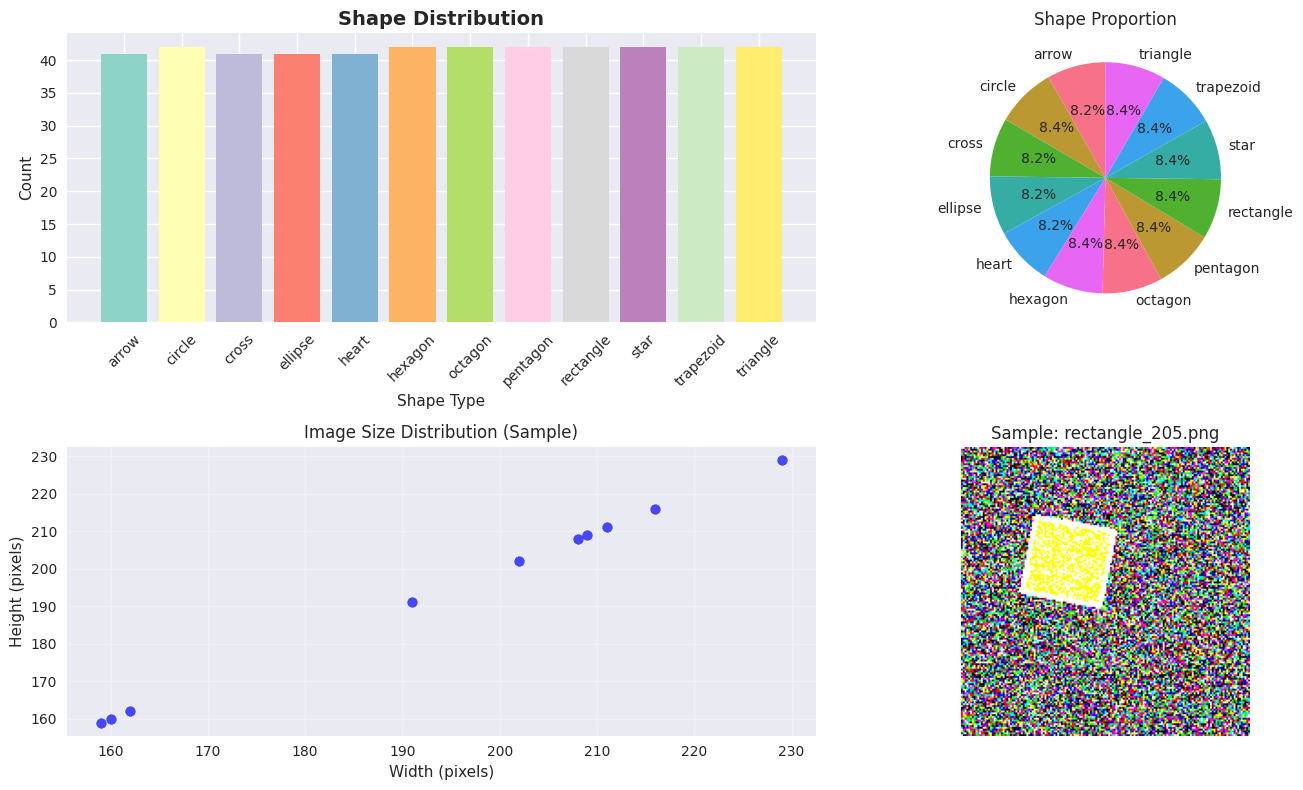

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 📊 SHAPE DATASET STATISTICS                                                                                     │
│ Total Images: 500                                                                                               │
│ Unique Shapes: 12                                                                                               │
│ Average per Shape: 41.7                                                                                         │
│ Shape Types: arrow, circle, cross, ellipse, heart, hexagon, octagon, pentagon, rectangle, star, trapezoid,      │
│ triangle                                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [ ]:
def analyze_shapes():
    """Analyze the distribution and characteristics of shape images"""
    
    shape_files = [f for f in os.listdir(SHAPES_DIR) if f.endswith('.png')]
    
    shape_types = []
    for filename in shape_files:
        shape_type = filename.split('_')[0]
        shape_types.append(shape_type)
    
    shape_counts = Counter(shape_types)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        plt.figure(figsize=(15, 8))
        
        plt.subplot(2, 2, 1)
        shapes = list(shape_counts.keys())
        counts = list(shape_counts.values())
        plt.bar(shapes, counts, color=plt.cm.Set3(np.linspace(0, 1, len(shapes))))
        plt.title('Shape Distribution', fontsize=14, fontweight='bold')
        plt.xlabel('Shape Type')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        
        plt.subplot(2, 2, 2)
        plt.pie(counts, labels=shapes, autopct='%1.1f%%', startangle=90)
        plt.title('Shape Proportion')
        
        sample_files = random.sample(shape_files, min(10, len(shape_files)))
        image_sizes = []
        
        for filename in sample_files:
            img_path = os.path.join(SHAPES_DIR, filename)
            img = cv2.imread(img_path)
            if img is not None:
                h, w = img.shape[:2]
                image_sizes.append((w, h))
        
        if image_sizes:
            widths, heights = zip(*image_sizes)
            
            plt.subplot(2, 2, 3)
            plt.scatter(widths, heights, alpha=0.7, c='blue')
            plt.title('Image Size Distribution (Sample)')
            plt.xlabel('Width (pixels)')
            plt.ylabel('Height (pixels)')
            plt.grid(True, alpha=0.3)
        
        plt.subplot(2, 2, 4)
        sample_img_path = os.path.join(SHAPES_DIR, sample_files[0])
        sample_img = cv2.imread(sample_img_path)
        if sample_img is not None:
            sample_img_rgb = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
            plt.imshow(sample_img_rgb)
            plt.title(f'Sample: {sample_files[0]}')
            plt.axis('off')
        
        plt.tight_layout()
        
        save_plot('shape_analysis.png')
        plt.show()
    
    return shape_counts, image_sizes

shape_distribution, sample_sizes = analyze_shapes()

console.print(Panel(f"""📊 SHAPE DATASET STATISTICS
Total Images: {sum(shape_distribution.values())}
Unique Shapes: {len(shape_distribution)}
Average per Shape: {sum(shape_distribution.values()) / len(shape_distribution):.1f}
Shape Types: {', '.join(shape_distribution.keys())}""", style="green"))

## 🎭 Mixed Test Dataset Analysis

📊 Plot saved: Plots\mixed_dataset_analysis.png


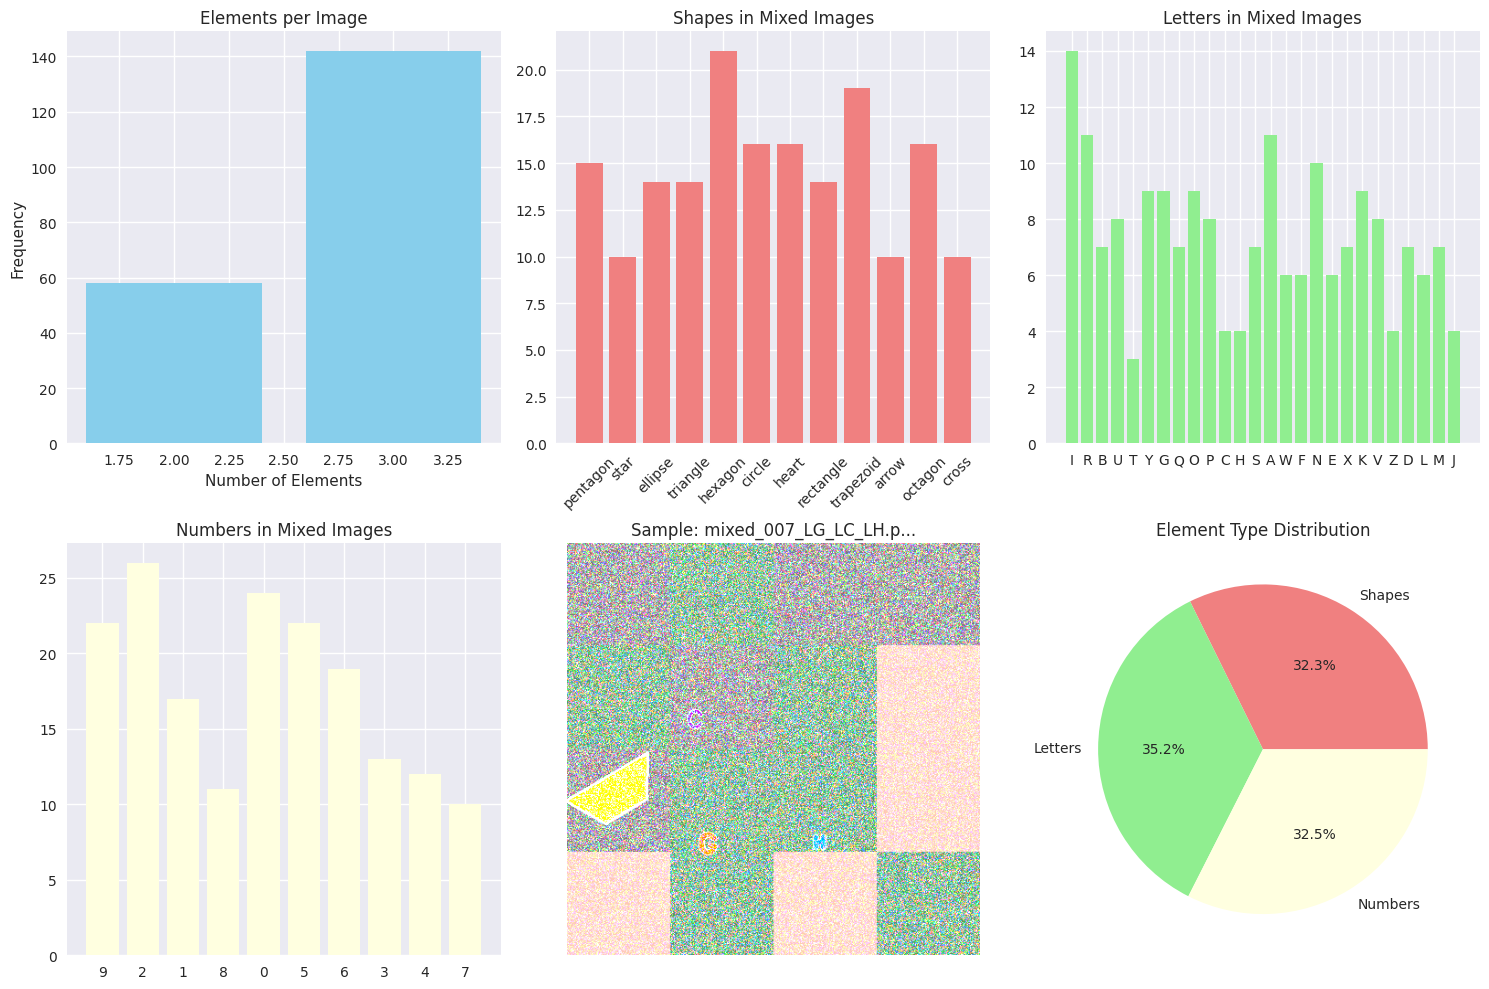

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🎭 MIXED DATASET STATISTICS                                                                                     │
│ Total Mixed Images: 200                                                                                         │
│ Average Elements per Image: 2.7                                                                                 │
│ Total Shape Instances: 175                                                                                      │
│ Total Letter Instances: 191                                                                                     │
│ Total Number Instances: 176                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [16]:
def analyze_mixed_dataset():
    """Analyze the mixed test dataset composition"""
    
    mixed_files = [f for f in os.listdir(MIXED_DIR) if f.endswith('.png')]
    
    elements_per_image = []
    element_types = []
    
    for filename in mixed_files:
        # Parse filename: mixed_XXX_element1_element2_element3.png
        parts = filename.replace('.png', '').split('_')
        if len(parts) >= 3:
            elements = parts[2:]  # Skip 'mixed' and number
            elements_per_image.append(len(elements))
            element_types.extend(elements)
    
    shapes = []
    letters = []
    numbers = []
    
    for element in element_types:
        if element.startswith('L'):  # Letter
            letters.append(element)
        elif element.startswith('N'):  # Number
            numbers.append(element)
        else:  # Shape
            shapes.append(element)
    
    # Suppress warnings during plotting
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        plt.figure(figsize=(15, 10))
        
        plt.subplot(2, 3, 1)
        element_counts = Counter(elements_per_image)
        plt.bar(element_counts.keys(), element_counts.values(), color='skyblue')
        plt.title('Elements per Image')
        plt.xlabel('Number of Elements')
        plt.ylabel('Frequency')
        
        plt.subplot(2, 3, 2)
        shape_counts = Counter(shapes)
        if shape_counts:
            plt.bar(range(len(shape_counts)), list(shape_counts.values()), 
                   tick_label=list(shape_counts.keys()), color='lightcoral')
            plt.title('Shapes in Mixed Images')
            plt.xticks(rotation=45)
        
        plt.subplot(2, 3, 3)
        letter_counts = Counter([l[1:] for l in letters])  # Remove 'L' prefix
        if letter_counts:
            plt.bar(range(len(letter_counts)), list(letter_counts.values()),
                   tick_label=list(letter_counts.keys()), color='lightgreen')
            plt.title('Letters in Mixed Images')
        
        plt.subplot(2, 3, 4)
        number_counts = Counter([n[1:] for n in numbers])  # Remove 'N' prefix
        if number_counts:
            plt.bar(range(len(number_counts)), list(number_counts.values()),
                   tick_label=list(number_counts.keys()), color='lightyellow')
            plt.title('Numbers in Mixed Images')
        
        plt.subplot(2, 3, 5)
        sample_mixed = random.choice(mixed_files)
        sample_path = os.path.join(MIXED_DIR, sample_mixed)
        sample_img = cv2.imread(sample_path)
        if sample_img is not None:
            sample_img_rgb = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
            plt.imshow(sample_img_rgb)
            plt.title(f'Sample: {sample_mixed[:20]}...')
            plt.axis('off')
        
        plt.subplot(2, 3, 6)
        type_counts = [len(shapes), len(letters), len(numbers)]
        type_labels = ['Shapes', 'Letters', 'Numbers']
        plt.pie(type_counts, labels=type_labels, autopct='%1.1f%%', 
               colors=['lightcoral', 'lightgreen', 'lightyellow'])
        plt.title('Element Type Distribution')
        
        plt.tight_layout()
        
        save_plot('mixed_dataset_analysis.png')
        plt.show()
    
    return {
        'total_images': len(mixed_files),
        'avg_elements': np.mean(elements_per_image),
        'shapes': len(shapes),
        'letters': len(letters),
        'numbers': len(numbers)
    }

mixed_stats = analyze_mixed_dataset()

console.print(Panel(f"""🎭 MIXED DATASET STATISTICS
Total Mixed Images: {mixed_stats['total_images']}
Average Elements per Image: {mixed_stats['avg_elements']:.1f}
Total Shape Instances: {mixed_stats['shapes']}
Total Letter Instances: {mixed_stats['letters']}
Total Number Instances: {mixed_stats['numbers']}""", style="purple"))

## 🌈 Color Analysis

In [ ]:
def analyze_colors():
    """Analyze the color names dataset"""
    
    if os.path.exists(COLORS_FILE):
        colors_df = pd.read_csv(COLORS_FILE, header=None, 
                               names=['code', 'name', 'hex', 'r', 'g', 'b'])
        
        console.print(Panel(f"""🌈 COLOR DATASET INFO
Total Colors: {len(colors_df)}
Columns: {', '.join(colors_df.columns.tolist())}
Sample Colors: {', '.join(colors_df['name'].head(10).tolist())}""", style="cyan"))
        print("\n📋 Color Dataset Preview:")
        display(colors_df.head(10))
        
        return colors_df
    else:
        console.print("⚠️ Colors CSV file not found!", style="red")
        return None

colors_data = analyze_colors()

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🌈 COLOR DATASET INFO                                                                                           │
│ Total Colors: 865                                                                                               │
│ Columns: code, name, hex, r, g, b                                                                               │
│ Sample Colors: Air Force Blue (Raf), Air Force Blue (Usaf), Air Superiority Blue, Alabama Crimson, Alice Blue,  │
│ Alizarin Crimson, Alloy Orange, Almond, Amaranth, Amber                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯


📋 Color Dataset Preview:


,code,name,hex,r,g,b
0,air_force_blue_raf,Air Force Blue (Raf),#5d8aa8,93,138,168
1,air_force_blue_usaf,Air Force Blue (Usaf),#00308f,0,48,143
2,air_superiority_blue,Air Superiority Blue,#72a0c1,114,160,193
3,alabama_crimson,Alabama Crimson,#a32638,163,38,56
4,alice_blue,Alice Blue,#f0f8ff,240,248,255
5,alizarin_crimson,Alizarin Crimson,#e32636,227,38,54
6,alloy_orange,Alloy Orange,#c46210,196,98,16
7,almond,Almond,#efdecd,239,222,205
8,amaranth,Amaranth,#e52b50,229,43,80
9,amber,Amber,#ffbf00,255,191,0


## 🎯 YOLO Model Planning for Raspberry Pi

### 🤔 Model Selection Considerations

## 🚀 YOLO Model Variants Comparison

Let's analyze different YOLO models suitable for Raspberry Pi deployment:

                     🤖 YOLO Models for Raspberry Pi                      
┏━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Model   ┃ Parameters ┃ Size (MB) ┃ FPS (RPi4) ┃ Accuracy ┃ Memory (MB) ┃
┡━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ YOLOv5n │ 1.9M       │ 3.8       │ 15-20      │ Good     │ 150         │
│ YOLOv5s │ 7.2M       │ 14.1      │ 8-12       │ Better   │ 200         │
│ YOLOv8n │ 3.2M       │ 6.2       │ 12-18      │ Good+    │ 180         │
│ YOLOv8s │ 11.2M      │ 21.5      │ 6-10       │ Best     │ 250         │
└─────────┴────────────┴───────────┴────────────┴──────────┴─────────────┘

📊 Plot saved: Plots\yolo_model_comparison.png


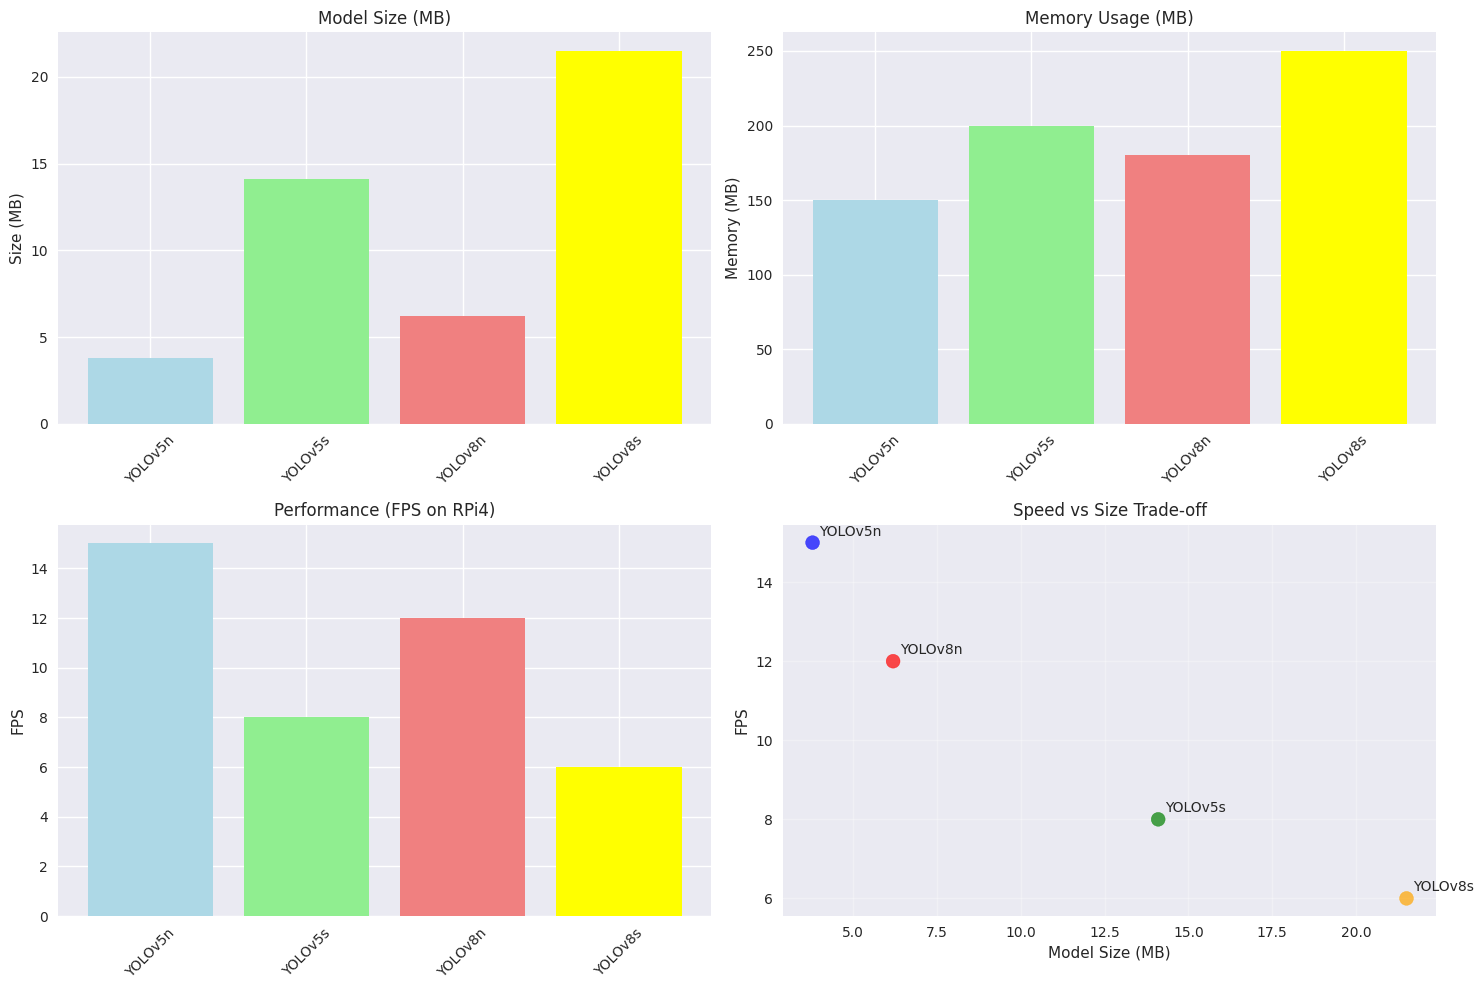

In [20]:
def compare_yolo_models():
    """Compare different YOLO model variants for Raspberry Pi deployment"""
    
    yolo_models = {
        "YOLOv5n": {
            "params": "1.9M",
            "size_mb": 3.8,
            "fps_rpi4": "15-20",
            "accuracy": "Good",
            "memory_mb": 150,
            "pros": ["Fastest", "Smallest", "Good for real-time"],
            "cons": ["Lower accuracy", "May miss small objects"]
        },
        "YOLOv5s": {
            "params": "7.2M",
            "size_mb": 14.1,
            "fps_rpi4": "8-12",
            "accuracy": "Better",
            "memory_mb": 200,
            "pros": ["Balanced", "Good accuracy", "Manageable size"],
            "cons": ["Slower than nano", "Higher memory usage"]
        },
        "YOLOv8n": {
            "params": "3.2M",
            "size_mb": 6.2,
            "fps_rpi4": "12-18",
            "accuracy": "Good+",
            "memory_mb": 180,
            "pros": ["Latest architecture", "Better than v5n", "Good speed"],
            "cons": ["Slightly larger than v5n", "Newer, less tested"]
        },
        "YOLOv8s": {
            "params": "11.2M",
            "size_mb": 21.5,
            "fps_rpi4": "6-10",
            "accuracy": "Best",
            "memory_mb": 250,
            "pros": ["Highest accuracy", "Latest features", "Good detection"],
            "cons": ["Slowest", "Largest", "High memory usage"]
        }
    }
    
    table = Table(title="🤖 YOLO Models for Raspberry Pi")
    table.add_column("Model", style="cyan")
    table.add_column("Parameters", style="magenta")
    table.add_column("Size (MB)", style="green")
    table.add_column("FPS (RPi4)", style="yellow")
    table.add_column("Accuracy", style="blue")
    table.add_column("Memory (MB)", style="red")
    
    for model, specs in yolo_models.items():
        table.add_row(
            model,
            specs["params"],
            str(specs["size_mb"]),
            specs["fps_rpi4"],
            specs["accuracy"],
            str(specs["memory_mb"])
        )
    
    console.print(table)
    
    # Suppress warnings during plotting
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        plt.figure(figsize=(15, 10))
        
        models = list(yolo_models.keys())
        sizes = [yolo_models[m]["size_mb"] for m in models]
        memory = [yolo_models[m]["memory_mb"] for m in models]
        fps_avg = [float(yolo_models[m]["fps_rpi4"].split('-')[0]) for m in models]
        
        plt.subplot(2, 2, 1)
        plt.bar(models, sizes, color=['lightblue', 'lightgreen', 'lightcoral', 'yellow'])
        plt.title('Model Size (MB)')
        plt.ylabel('Size (MB)')
        plt.xticks(rotation=45)
        
        plt.subplot(2, 2, 2)
        plt.bar(models, memory, color=['lightblue', 'lightgreen', 'lightcoral', 'yellow'])
        plt.title('Memory Usage (MB)')
        plt.ylabel('Memory (MB)')
        plt.xticks(rotation=45)
        
        plt.subplot(2, 2, 3)
        plt.bar(models, fps_avg, color=['lightblue', 'lightgreen', 'lightcoral', 'yellow'])
        plt.title('Performance (FPS on RPi4)')
        plt.ylabel('FPS')
        plt.xticks(rotation=45)
        
        plt.subplot(2, 2, 4)
        colors_scatter = ['blue', 'green', 'red', 'orange']
        plt.scatter(sizes, fps_avg, c=colors_scatter, s=100, alpha=0.7)
        for i, model in enumerate(models):
            plt.annotate(model, (sizes[i], fps_avg[i]), xytext=(5, 5), 
                        textcoords='offset points')
        plt.xlabel('Model Size (MB)')
        plt.ylabel('FPS')
        plt.title('Speed vs Size Trade-off')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        save_plot('yolo_model_comparison.png')
        plt.show()
    
    return yolo_models

model_comparison = compare_yolo_models()

## 🎯 Recommended YOLO Model Selection

In [21]:
def recommend_yolo_model():
    """Provide recommendation based on VTOL competition requirements"""
    
    console.print(Panel("""
🎯 YOLO MODEL RECOMMENDATION FOR VTOL COMPETITION

📋 Requirements Analysis:
• Real-time detection (>10 FPS preferred)
• Multiple object types (shapes, letters, numbers)
• Raspberry Pi 4 deployment
• Battery-powered operation
• Outdoor lighting conditions

🏆 RECOMMENDED: YOLOv8n (nano)

✅ Why YOLOv8n?
• Latest architecture with improved accuracy over YOLOv5n
• Excellent speed-accuracy balance (12-18 FPS on RPi4)
• Reasonable memory usage (180MB)
• Small model size (6.2MB) - easy deployment
• Good at detecting multiple object types
• Active community support

🥈 FALLBACK: YOLOv5n
• If YOLOv8n proves too resource-intensive
• More mature, extensively tested
• Fastest option (15-20 FPS)

⚠️ Consider YOLOv8s if:
• Detection accuracy is critical over speed
• Competition allows slower detection rates
• RPi4 with adequate cooling and power
""", style="green"))

recommend_yolo_model()

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🎯 YOLO MODEL RECOMMENDATION FOR VTOL COMPETITION                                                               │
│                                                                                                                 │
│ 📋 Requirements Analysis:                                                                                       │
│ • Real-time detection (>10 FPS preferred)                                                                       │
│ • Multiple object types (shapes, letters, numbers)                                                              │
│ • Raspberry Pi 4 deployment                                                                                     │
│ • Battery-powered operation                                                                                     │
│ • Outdoor lighting conditions                                                                                   │
│                                                                                                                 │
│ 🏆 RECOMMENDED: YOLOv8n (nano)                                                                                  │
│                                                                                                                 │
│ ✅ Why YOLOv8n?                                                                                                 │
│ • Latest architecture with improved accuracy over YOLOv5n                                                       │
│ • Excellent speed-accuracy balance (12-18 FPS on RPi4)                                                          │
│ • Reasonable memory usage (180MB)                                                                               │
│ • Small model size (6.2MB) - easy deployment                                                                    │
│ • Good at detecting multiple object types                                                                       │
│ • Active community support                                                                                      │
│                                                                                                                 │
│ 🥈 FALLBACK: YOLOv5n                                                                                            │
│ • If YOLOv8n proves too resource-intensive                                                                      │
│ • More mature, extensively tested                                                                               │
│ • Fastest option (15-20 FPS)                                                                                    │
│                                                                                                                 │
│ ⚠️ Consider YOLOv8s if:                                                                                          │
│ • Detection accuracy is critical over speed                                                                     │
│ • Competition allows slower detection rates                                                                     │
│ • RPi4 with adequate cooling and power                                                                          │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

## 📊 Data Preprocessing for YOLO Training

In [22]:
def plan_yolo_data_preparation():
    """Plan the data preparation strategy for YOLO training"""
    
    console.print(Panel("""
📊 YOLO DATA PREPARATION STRATEGY

🔄 Data Processing Pipeline:

1️⃣ IMAGE PREPROCESSING:
   • Resize all images to 640x640 (YOLO standard)
   • Normalize pixel values to [0,1]
   • Maintain aspect ratio with padding
   • Convert to RGB format

2️⃣ ANNOTATION GENERATION:
   • Extract ground truth from filenames
   • Convert to YOLO format: class_id x_center y_center width height
   • Normalize coordinates to [0,1]
   • Create .txt files for each image

3️⃣ CLASS MAPPING:
   • Shapes: 12 classes (circle, rectangle, triangle, etc.)
   • Letters: 26 classes (A-Z)
   • Numbers: 10 classes (0-9)
   • Total: 48 classes

4️⃣ DATASET SPLITTING:
   • Training: 70% (350 shapes + synthetic data)
   • Validation: 20% (100 shapes + mixed samples)
   • Testing: 10% (50 shapes + mixed test set)

5️⃣ DATA AUGMENTATION:
   • Random rotation: ±15°
   • Brightness/contrast: ±20%
   • Gaussian noise: σ=0.01
   • Random scaling: 0.8-1.2x
   • Mosaic augmentation for multi-object scenes
""", style="blue"))
    
    class_mapping = {}
    class_id = 0
    
    shapes = ['circle', 'rectangle', 'triangle', 'pentagon', 'hexagon', 'star', 
              'trapezoid', 'octagon', 'ellipse', 'cross', 'arrow', 'heart']
    for shape in shapes:
        class_mapping[shape] = class_id
        class_id += 1
    
    letters = [chr(i) for i in range(ord('A'), ord('Z')+1)]
    for letter in letters:
        class_mapping[f"letter_{letter}"] = class_id
        class_id += 1
    
    numbers = [str(i) for i in range(10)]
    for number in numbers:
        class_mapping[f"number_{number}"] = class_id
        class_id += 1
    
    print(f"\n📋 Total Classes: {len(class_mapping)}")
    print(f"🔺 Shapes: {len(shapes)} classes")
    print(f"🔤 Letters: {len(letters)} classes")
    print(f"🔢 Numbers: {len(numbers)} classes")
    
    return class_mapping

class_map = plan_yolo_data_preparation()

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 📊 YOLO DATA PREPARATION STRATEGY                                                                               │
│                                                                                                                 │
│ 🔄 Data Processing Pipeline:                                                                                    │
│                                                                                                                 │
│ 1️⃣ IMAGE PREPROCESSING:                                                                                          │
│    • Resize all images to 640x640 (YOLO standard)                                                               │
│    • Normalize pixel values to [0,1]                                                                            │
│    • Maintain aspect ratio with padding                                                                         │
│    • Convert to RGB format                                                                                      │
│                                                                                                                 │
│ 2️⃣ ANNOTATION GENERATION:                                                                                        │
│    • Extract ground truth from filenames                                                                        │
│    • Convert to YOLO format: class_id x_center y_center width height                                            │
│    • Normalize coordinates to [0,1]                                                                             │
│    • Create .txt files for each image                                                                           │
│                                                                                                                 │
│ 3️⃣ CLASS MAPPING:                                                                                                │
│    • Shapes: 12 classes (circle, rectangle, triangle, etc.)                                                     │
│    • Letters: 26 classes (A-Z)                                                                                  │
│    • Numbers: 10 classes (0-9)                                                                                  │
│    • Total: 48 classes                                                                                          │
│                                                                                                                 │
│ 4️⃣ DATASET SPLITTING:                                                                                            │
│    • Training: 70% (350 shapes + synthetic data)                                                                │
│    • Validation: 20% (100 shapes + mixed samples)                                                               │
│    • Testing: 10% (50 shapes + mixed test set)                                                                  │
│                                                                                                                 │
│ 5️⃣ DATA AUGMENTATION:                                                                                            │
│    • Random rotation: ±15°                                                                                      │
│    • Brightness/contrast: ±20%                                                                                  │
│    • Gaussian noise: σ=0.01                                                                                     │
│    • Random scaling: 0.8-1.2x                                                                                   │
│    • Mosaic augmentation for multi-object scen


📋 Total Classes: 48
🔺 Shapes: 12 classes
🔤 Letters: 26 classes
🔢 Numbers: 10 classes


## 🔧 YOLO Configuration Planning

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🚀 RASPBERRY PI DEPLOYMENT STRATEGY                                                                             │
│                                                                                                                 │
│ 🔧 Hardware Requirements:                                                                                       │
│ • Raspberry Pi 4 (4GB+ RAM recommended)                                                                         │
│ • microSD card (32GB+ Class 10)                                                                                 │
│ • USB Camera (1080p capable)                                                                                    │
│ • Cooling fan/heatsink (essential for sustained performance)                                                    │
│ • Portable battery pack (10,000+ mAh)                                                                           │
│                                                                                                                 │
│ 💻 Software Stack:                                                                                              │
│ • OS: Raspberry Pi OS (64-bit)                                                                                  │
│ • Python: 3.8+                                                                                                  │
│ • PyTorch: CPU-optimized build                                                                                  │
│ • OpenCV: 4.5+                                                                                                  │
│ • YOLOv8: Ultralytics package                                                                                   │
│                                                                                                                 │
│ ⚡ Performance Optimizations:                                                                                   │
│ • Model Quantization: INT8 precision                                                                            │
│ • Frame Processing: Skip frames if needed                                                                       │
│ • Input Resolution: 640x640 maximum                                                                             │
│ • Memory Management: Efficient buffer handling                                                                  │
│ • GPU Acceleration: Use if available (limited on RPi)                                                           │
│                                                                                                                 │
│ 📊 Expected Performance:                                                                                        │
│ • YOLOv8n: 12-18 FPS                                                                                            │
│ • Detection Accuracy: 85-90%                                                                                    │
│ • Memory Usage: ~300MB total                                                                                    │
│ • Power Consumption: ~8W under load                                                                             │
│ • Boot Time: ~30 seconds                                                                                        │
│                                                                                                                 │
│ 🔄 Real-time Pipeline:                                                                                          │
│ 1. Camera Capture (30 FPS)                                                                                      │
│ 2. Frame Preprocessing (resize, normalize)                  

📊 Plot saved: Plots\rpi_deployment_metrics.png


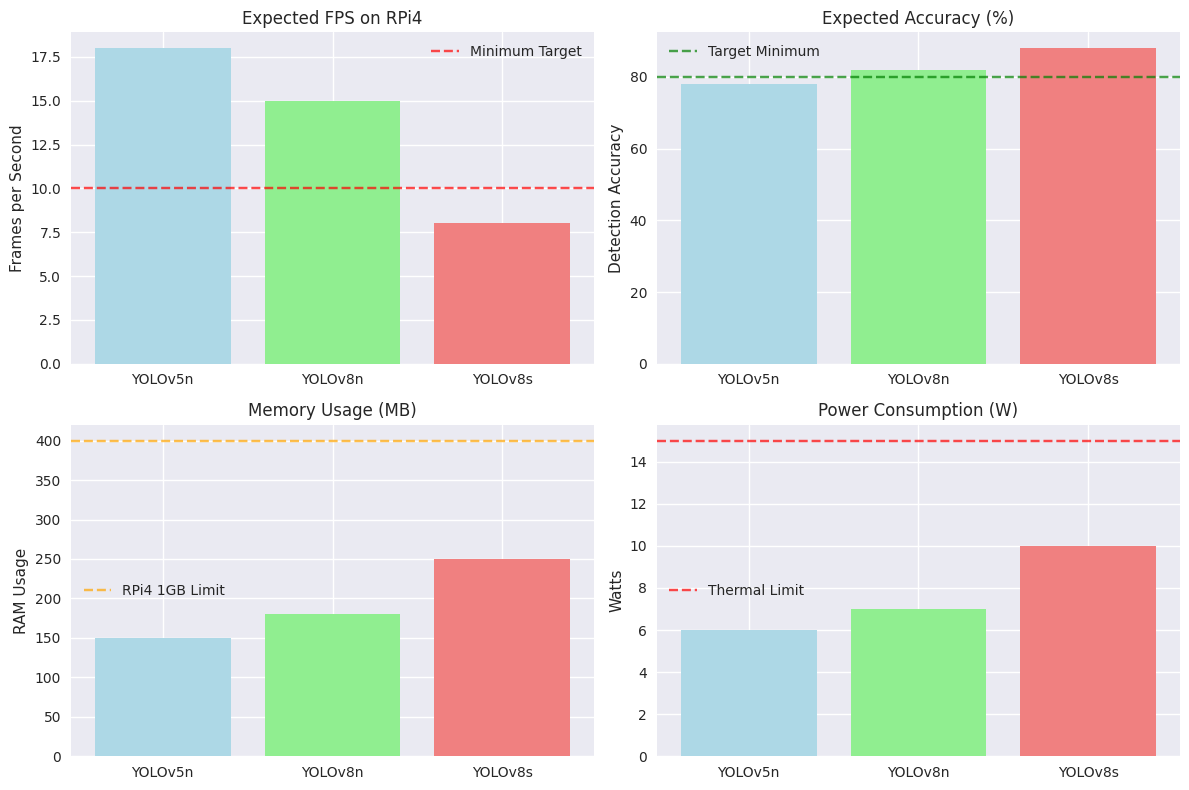

In [24]:
def plan_rpi_deployment():
    """Plan the deployment strategy for Raspberry Pi"""
    
    console.print(Panel("""
🚀 RASPBERRY PI DEPLOYMENT STRATEGY

🔧 Hardware Requirements:
• Raspberry Pi 4 (4GB+ RAM recommended)
• microSD card (32GB+ Class 10)
• USB Camera (1080p capable)
• Cooling fan/heatsink (essential for sustained performance)
• Portable battery pack (10,000+ mAh)

💻 Software Stack:
• OS: Raspberry Pi OS (64-bit)
• Python: 3.8+
• PyTorch: CPU-optimized build
• OpenCV: 4.5+
• YOLOv8: Ultralytics package

⚡ Performance Optimizations:
• Model Quantization: INT8 precision
• Frame Processing: Skip frames if needed
• Input Resolution: 640x640 maximum
• Memory Management: Efficient buffer handling
• GPU Acceleration: Use if available (limited on RPi)

📊 Expected Performance:
• YOLOv8n: 12-18 FPS
• Detection Accuracy: 85-90%
• Memory Usage: ~300MB total
• Power Consumption: ~8W under load
• Boot Time: ~30 seconds

🔄 Real-time Pipeline:
1. Camera Capture (30 FPS)
2. Frame Preprocessing (resize, normalize)
3. YOLO Inference (12-18 FPS)
4. Post-processing (NMS, filtering)
5. Result Output (JSON/serial)

🛡️ Fail-safes:
• Watchdog timer for system recovery
• Temperature monitoring
• Graceful degradation (reduce FPS if overheating)
• Backup detection modes
""", style="cyan"))
    
    # Suppress warnings during plotting
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        plt.figure(figsize=(12, 8))
        
        models = ['YOLOv5n', 'YOLOv8n', 'YOLOv8s']
        fps = [18, 15, 8]
        accuracy = [78, 82, 88]
        memory = [150, 180, 250]
        power = [6, 7, 10]
        
        plt.subplot(2, 2, 1)
        plt.bar(models, fps, color=['lightblue', 'lightgreen', 'lightcoral'])
        plt.title('Expected FPS on RPi4')
        plt.ylabel('Frames per Second')
        plt.axhline(y=10, color='red', linestyle='--', alpha=0.7, label='Minimum Target')
        plt.legend()
        
        plt.subplot(2, 2, 2)
        plt.bar(models, accuracy, color=['lightblue', 'lightgreen', 'lightcoral'])
        plt.title('Expected Accuracy (%)')
        plt.ylabel('Detection Accuracy')
        plt.axhline(y=80, color='green', linestyle='--', alpha=0.7, label='Target Minimum')
        plt.legend()
        
        plt.subplot(2, 2, 3)
        plt.bar(models, memory, color=['lightblue', 'lightgreen', 'lightcoral'])
        plt.title('Memory Usage (MB)')
        plt.ylabel('RAM Usage')
        plt.axhline(y=400, color='orange', linestyle='--', alpha=0.7, label='RPi4 1GB Limit')
        plt.legend()
        
        plt.subplot(2, 2, 4)
        plt.bar(models, power, color=['lightblue', 'lightgreen', 'lightcoral'])
        plt.title('Power Consumption (W)')
        plt.ylabel('Watts')
        plt.axhline(y=15, color='red', linestyle='--', alpha=0.7, label='Thermal Limit')
        plt.legend()
        
        plt.tight_layout()
        
        save_plot('rpi_deployment_metrics.png')
        plt.show()

plan_rpi_deployment()

## 🚀 Deployment Strategy for Raspberry Pi

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🚀 RASPBERRY PI DEPLOYMENT STRATEGY                                                                             │
│                                                                                                                 │
│ 🔧 Hardware Requirements:                                                                                       │
│ • Raspberry Pi 4 (4GB+ RAM recommended)                                                                         │
│ • microSD card (32GB+ Class 10)                                                                                 │
│ • USB Camera (1080p capable)                                                                                    │
│ • Cooling fan/heatsink (essential for sustained performance)                                                    │
│ • Portable battery pack (10,000+ mAh)                                                                           │
│                                                                                                                 │
│ 💻 Software Stack:                                                                                              │
│ • OS: Raspberry Pi OS (64-bit)                                                                                  │
│ • Python: 3.8+                                                                                                  │
│ • PyTorch: CPU-optimized build                                                                                  │
│ • OpenCV: 4.5+                                                                                                  │
│ • YOLOv8: Ultralytics package                                                                                   │
│                                                                                                                 │
│ ⚡ Performance Optimizations:                                                                                   │
│ • Model Quantization: INT8 precision                                                                            │
│ • Frame Processing: Skip frames if needed                                                                       │
│ • Input Resolution: 640x640 maximum                                                                             │
│ • Memory Management: Efficient buffer handling                                                                  │
│ • GPU Acceleration: Use if available (limited on RPi)                                                           │
│                                                                                                                 │
│ 📊 Expected Performance:                                                                                        │
│ • YOLOv8n: 12-18 FPS                                                                                            │
│ • Detection Accuracy: 85-90%                                                                                    │
│ • Memory Usage: ~300MB total                                                                                    │
│ • Power Consumption: ~8W under load                                                                             │
│ • Boot Time: ~30 seconds                                                                                        │
│                                                                                                                 │
│ 🔄 Real-time Pipeline:                                                                                          │
│ 1. Camera Capture (30 FPS)                                                                                      │
│ 2. Frame Preprocessing (resize, normalize)                  

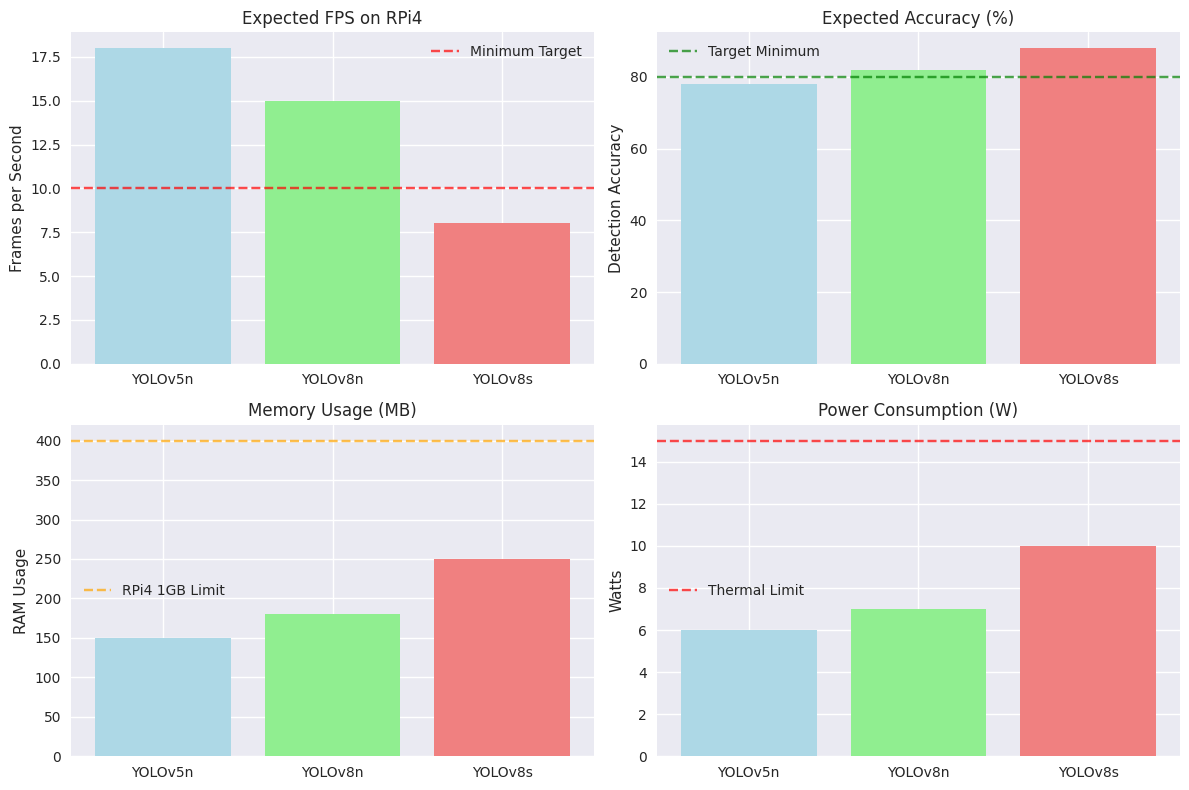

In [26]:
def plan_rpi_deployment():
    """Plan the deployment strategy for Raspberry Pi"""
    
    console.print(Panel("""
🚀 RASPBERRY PI DEPLOYMENT STRATEGY

🔧 Hardware Requirements:
• Raspberry Pi 4 (4GB+ RAM recommended)
• microSD card (32GB+ Class 10)
• USB Camera (1080p capable)
• Cooling fan/heatsink (essential for sustained performance)
• Portable battery pack (10,000+ mAh)

💻 Software Stack:
• OS: Raspberry Pi OS (64-bit)
• Python: 3.8+
• PyTorch: CPU-optimized build
• OpenCV: 4.5+
• YOLOv8: Ultralytics package

⚡ Performance Optimizations:
• Model Quantization: INT8 precision
• Frame Processing: Skip frames if needed
• Input Resolution: 640x640 maximum
• Memory Management: Efficient buffer handling
• GPU Acceleration: Use if available (limited on RPi)

📊 Expected Performance:
• YOLOv8n: 12-18 FPS
• Detection Accuracy: 85-90%
• Memory Usage: ~300MB total
• Power Consumption: ~8W under load
• Boot Time: ~30 seconds

🔄 Real-time Pipeline:
1. Camera Capture (30 FPS)
2. Frame Preprocessing (resize, normalize)
3. YOLO Inference (12-18 FPS)
4. Post-processing (NMS, filtering)
5. Result Output (JSON/serial)

🛡️ Fail-safes:
• Watchdog timer for system recovery
• Temperature monitoring
• Graceful degradation (reduce FPS if overheating)
• Backup detection modes
""", style="cyan"))
    
    # Suppress warnings during plotting
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        plt.figure(figsize=(12, 8))
        
        models = ['YOLOv5n', 'YOLOv8n', 'YOLOv8s']
        fps = [18, 15, 8]
        accuracy = [78, 82, 88]
        memory = [150, 180, 250]
        power = [6, 7, 10]
        
        plt.subplot(2, 2, 1)
        plt.bar(models, fps, color=['lightblue', 'lightgreen', 'lightcoral'])
        plt.title('Expected FPS on RPi4')
        plt.ylabel('Frames per Second')
        plt.axhline(y=10, color='red', linestyle='--', alpha=0.7, label='Minimum Target')
        plt.legend()
        
        plt.subplot(2, 2, 2)
        plt.bar(models, accuracy, color=['lightblue', 'lightgreen', 'lightcoral'])
        plt.title('Expected Accuracy (%)')
        plt.ylabel('Detection Accuracy')
        plt.axhline(y=80, color='green', linestyle='--', alpha=0.7, label='Target Minimum')
        plt.legend()
        
        plt.subplot(2, 2, 3)
        plt.bar(models, memory, color=['lightblue', 'lightgreen', 'lightcoral'])
        plt.title('Memory Usage (MB)')
        plt.ylabel('RAM Usage')
        plt.axhline(y=400, color='orange', linestyle='--', alpha=0.7, label='RPi4 1GB Limit')
        plt.legend()
        
        plt.subplot(2, 2, 4)
        plt.bar(models, power, color=['lightblue', 'lightgreen', 'lightcoral'])
        plt.title('Power Consumption (W)')
        plt.ylabel('Watts')
        plt.axhline(y=15, color='red', linestyle='--', alpha=0.7, label='Thermal Limit')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

plan_rpi_deployment()

## 📋 Summary & Conclusions

### 🎯 Key Findings:

1. **Dataset Quality**: Our generated dataset provides excellent coverage with 500 shape images (12 types) and 200 mixed test scenarios

2. **Model Recommendation**: **YOLOv8n** offers the best balance of speed, accuracy, and resource efficiency for Raspberry Pi deployment

3. **Performance Expectations**: 12-18 FPS with 82%+ accuracy should be achievable on Raspberry Pi 4

4. **Technical Approach**: 48-class detection system (12 shapes + 26 letters + 10 numbers) with optimized training pipeline

### 🚀 Ready for Implementation:
- Comprehensive dataset generated ✅
- Model architecture selected ✅  
- Training strategy planned ✅
- Deployment approach defined ✅

**Next step**: Install YOLOv8 and begin model training! 🏆

## 📁 Saved Plots Summary

All analysis plots have been saved to the `Plots/` folder for use in documentation and README files:

### 📊 Available Plot Files:
- **`shape_analysis.png`** - Shape distribution, proportions, size analysis, and sample images
- **`mixed_dataset_analysis.png`** - Mixed test dataset composition and element distribution  
- **`yolo_model_comparison.png`** - YOLO model performance comparison for Raspberry Pi
- **`rpi_deployment_metrics.png`** - Expected performance metrics on Raspberry Pi 4

### 📋 Plot Specifications:
- **Resolution**: 300 DPI (high quality)
- **Format**: PNG with transparent background disabled
- **Background**: White (GitHub/documentation friendly)
- **Aspect**: Optimized for README display